In [1]:
suppressPackageStartupMessages({
  library(tidyverse)
  library(janitor)
  library(tidymodels)
  library(repr)
  library(GGally)
})

# Predictive Modelling of Newsletter Subscription Among Minecraft Players: The Roles of Experience, Age, and Play-time

## Introduction

Understanding player engagement is a key component of game-related research and video-game analytics, as it allows researchers to identify how players interact with their platform. Newsletters not only function as a useful communication tool, but also provide an indirect indication of player engagement with the game, the company, and the ongoing development. Identifying the characteristics of players who choose to subscribe to a newsletter can potentially be of use to game developers and marketing researchers. This insight can be used to better understand what drives appeal and to develop strategies that enhance user engagement, which can help tailor future newsletters to different player demographics. 

In this project, we aim to investigate the following questions:

**Broad Question**: What player characteristics and behaviours are most predictive of subscribing to a game-related newsletter, and how do these features differ between various player types?

**Specific question**: Could experience, game-play time, and age predict whether or not an individual will subscribe to the Minecraft research newsletter in the player dataset?

As stated in our specific question, we selected the three following variables: experience, game-play time, and age as predictors. These metrics capture different features related to user engagement:
1) **Experience**: This variable reflects the user's skill level in the game. More experienced players may feel more invested in the game, and subsequently show more interest in ongoing research and game development. Thus, player experience may be a useful variable to predict subscription to a game-related newsletter.
2) **Game-play time**: Total game-play time is the most intuitive measure of player engagement. Individuals that spend more time playing the game may be more likely to show interest in game-related newsletters and updates.
3) **Age**: Age is a relevant demographic factor, because different age groups may have different incentives and motivations to play. Younger players may show less interest in reading news/updates, while older players may appreciate consistent progress updates, making age a potentially useful predictor for newsletter subscription. 



To answer these questions, we use the ```players.csv``` dataset, shown below, as well as a table describing all the variables:

In [2]:
players <- read_csv("players.csv") |>
clean_names() 
head(players)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashed_email,played_hours,name,gender,age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


**Players Data Set**: The players.csv data set describes data regarding individual players of the game. It has 196 observations with the 7 following variables: 
|Variable|Data Type|Description|
|---|---|---|
|**experience**|Character|Describes the players' experience with the game as either "Pro", "Veteran", "Regular", or "Amateur"|
|**subscribe**|Logical|Displays "TRUE" if the player is subscribed to the newsletter, and "FALSE" if they are not|
|**hashedEmail**|Character|The unique identification (privacy safe way of displaying email) of the player|
|**played_hours**|Double|Amount of time (hours) players played during all sessions|
|**name**|Character|Players' first name|
|**gender**|Character|Players' gender as "Female", "Male", "Agender", "Two Spirited", "Non-Binary", or "Prefer not to say"|
|**Age**|Double|Players' age in years|



**Summary Statistics:**
|Variable |Min | Max | Mean  | Q1 | Q2 | Q3 |
|---------|----|-----|------|-----|----|----|
|played_hours (hrs)|0.00|223.10|5.85|0.00|0.10|0.60|
|Age (years)|9.00|58.00|21.14|17.00|19.00|22.75|

In [3]:
## included this, can add quartiles to these if we want to, just added these in case we want to show how we calculated the numbers
hours_stats <- players |>
  summarize(min_hours = round(min(played_hours, na.rm = TRUE), 2),
    max_hours = round(max(played_hours, na.rm = TRUE), 2),
    mean_hours = round(mean(played_hours, na.rm = TRUE), 2),
    median_hours = round(median(played_hours, na.rm = TRUE), 2),
    total_players = n())

age_stats <- players |>
  summarise(min_age = round(min(age, na.rm = TRUE), 2),
    max_age = round(max(age, na.rm = TRUE), 2),
    mean_age = round(mean(age, na.rm = TRUE), 2),
    median_age = round(median(age, na.rm = TRUE), 2),
    total_players = n())

hours_stats
age_stats

min_hours,max_hours,mean_hours,median_hours,total_players
<dbl>,<dbl>,<dbl>,<dbl>,<int>
0,223.1,5.85,0.1,196


min_age,max_age,mean_age,median_age,total_players
<dbl>,<dbl>,<dbl>,<dbl>,<int>
9,58,21.14,19,196


Below are are some potential issues with this dataset:

- ```min_hours = 0```: some players registered but never played. This indicates that some data might be missing.
- ```max_hours = 223.1```: data is positively skewed. Subsequently, ```mean_hours``` may be inflated.
- Some players did not report ```Age```. This could lead to bias and reduces the effective sample size.

<h2>Methods and Results</h2>

The goal of predicting players' subscription status using the variables Age, Experience Level, and Hours Played from the "players.csv" dataset can be appropriately performed through KNN Classification. Because the outcome of our predictive question - whether a player will subscribe to the Minecraft Research Newsletter - is binary (TRUE or FALSE), our chosen response variable is categorical. Hence, the KNN classification model is a useful approach to address this question as it makes no assumptions about the distribution of our data, which is helpful given the lack of visible relationships among the three predictors. 

<h4>Preliminary visualization of predictor variables</h4>
First, to examine the variables in the dataset, summary plots are generated:

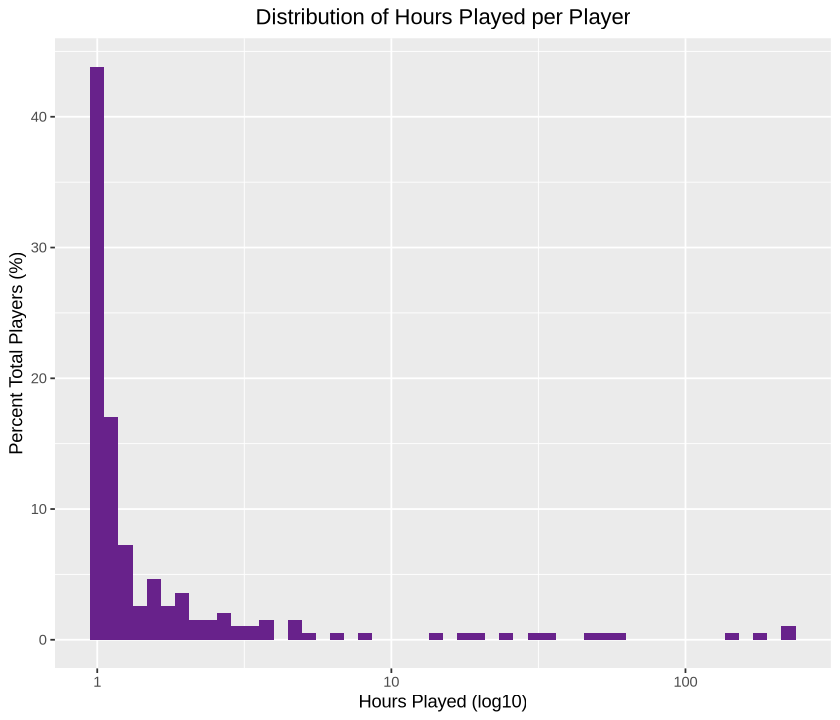

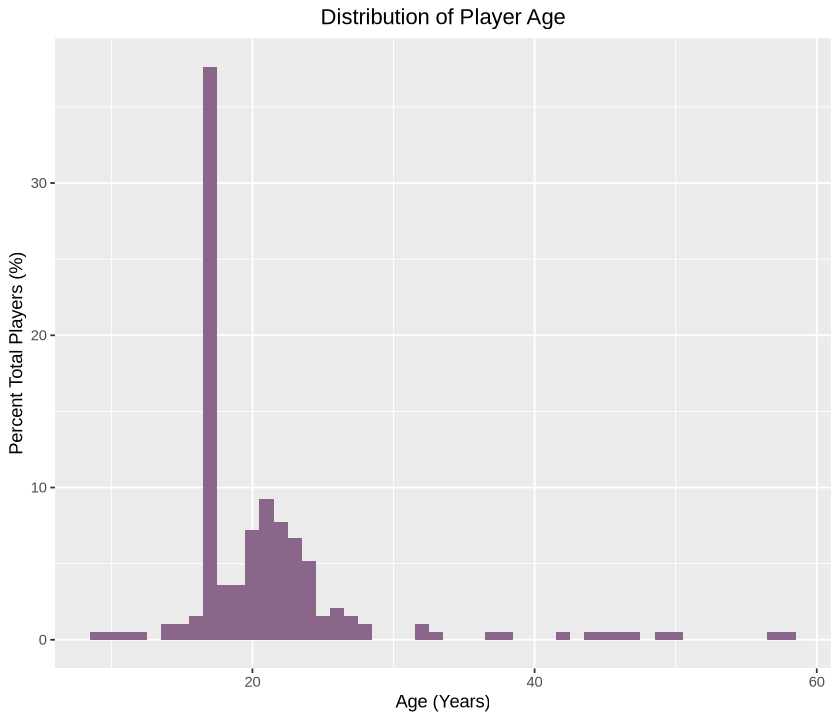

subscribe,n,pct
<fct>,<int>,<dbl>
FALSE,52,26.8
TRUE,142,73.2


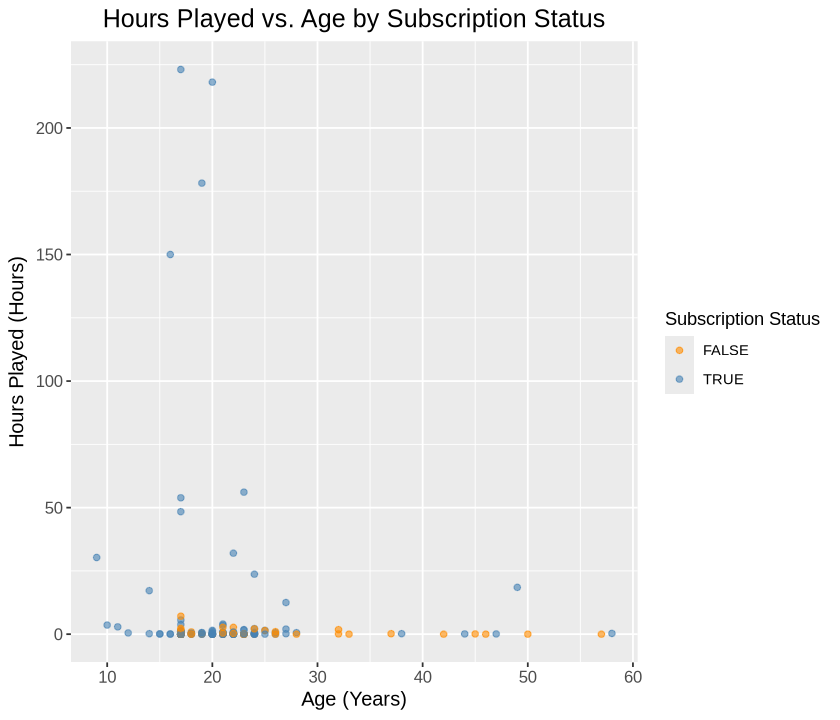

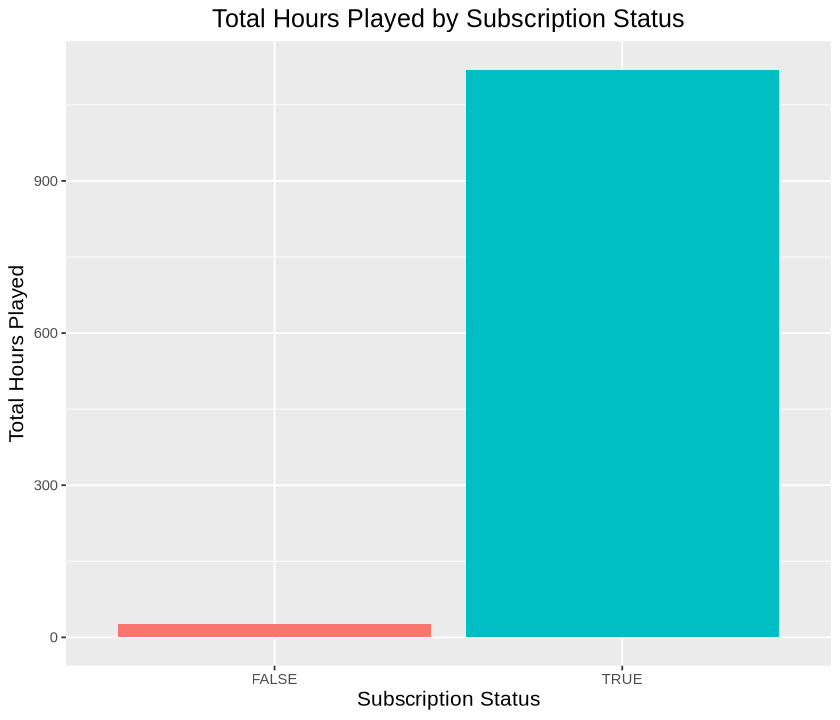

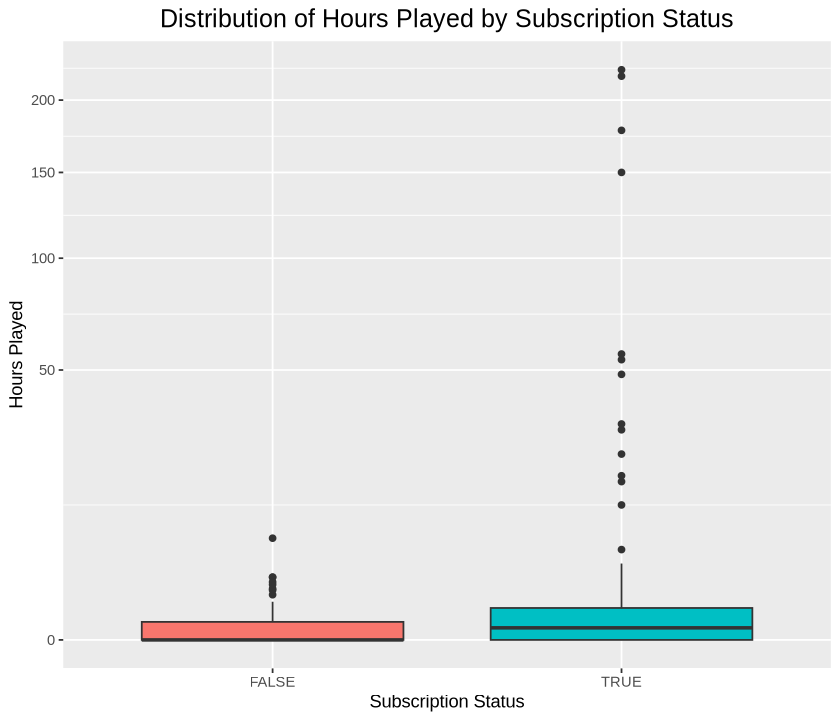

In [11]:
options(repr.plot.width = 7, repr.plot.height = 6)

## create histogram of hours played per player
hours_hist <- players |>
    ggplot(aes(x = played_hours + 1)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'darkorchid4') +
    labs(title = 'Distribution of Hours Played per Player',
         x = 'Hours Played (log10)',
         y = 'Percent Total Players (%)') +
    scale_x_log10() +
    theme(plot.title = element_text(hjust = 0.5))
hours_hist


## create histogram of players' ages
age_hist <- players |>
    ggplot(aes(x = age)) +
    geom_histogram(bins = 50,
                   aes(y = after_stat(count/sum(count) * 100)),
                  fill = 'plum4') +
    labs(title = 'Distribution of Player Age',
         x = 'Age (Years)',
         y = 'Percent Total Players (%)') +
    theme(plot.title = element_text(hjust = 0.5))
age_hist

## create plot of hours played vs age, group by subscription status
age_hours_plot <- players |> 
    ggplot(aes(x = age, y = played_hours, color = subscribe)) +
    geom_point(alpha = 0.6) + 
    labs(title = 'Hours Played vs. Age by Subscription Status', 
         x = 'Age (Years)',
         y = 'Hours Played (Hours)',
        color = 'Subscription Status') + 
    theme(plot.title = element_text(size = 15, hjust = 0.5),
         axis.title = element_text(size = 12),
         axis.text = element_text(size = 10)) +
    scale_color_manual(values = c('darkorange', 'steelblue'))

age_hours_plot

## summarise pct players where subscribe = TRUE/FALSE:
pct_true <- players |>
  count(subscribe) |>
  mutate(pct = round(n/sum(n)*100, 2))
pct_true

## create bar chart
sub_hours_bar <- players |>
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_bar(stat = "identity") +
    labs(title = "Total Hours Played by Subscription Status",
         x = "Subscription Status", 
         y = "Total Hours Played") +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
          axis.title = element_text(size = 12.5),
         legend.position = 'none')
sub_hours_bar


## create box plot
sub_hours_box <- players |> 
    ggplot(aes(x = subscribe, y = played_hours, fill = subscribe)) +
    geom_boxplot() +
    labs(title = "Distribution of Hours Played by Subscription Status",
         x = "Subscription Status",
         y = "Hours Played") + 
    scale_y_sqrt() +
    theme(plot.title = element_text(hjust = 0.5, size = 15),
         legend.position = "none")
sub_hours_box

<h4>Relationship Between 3 Chosen Predictors</h4>

Next, the relationship between age, experience, and played_hours can be examined through a ggpairs plot.

Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_density()`).”
Warning message:
“Removed 2 rows containing non-finite outside the scale range
(`stat_boxplot()`).”
Warning message in ggally_statistic(data = data, mapping = mapping, na.rm = na.rm, :
“Removed 2 rows containing missing values”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
Warning message:
“Removed 2 rows containing non-finite outside the scale range (`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


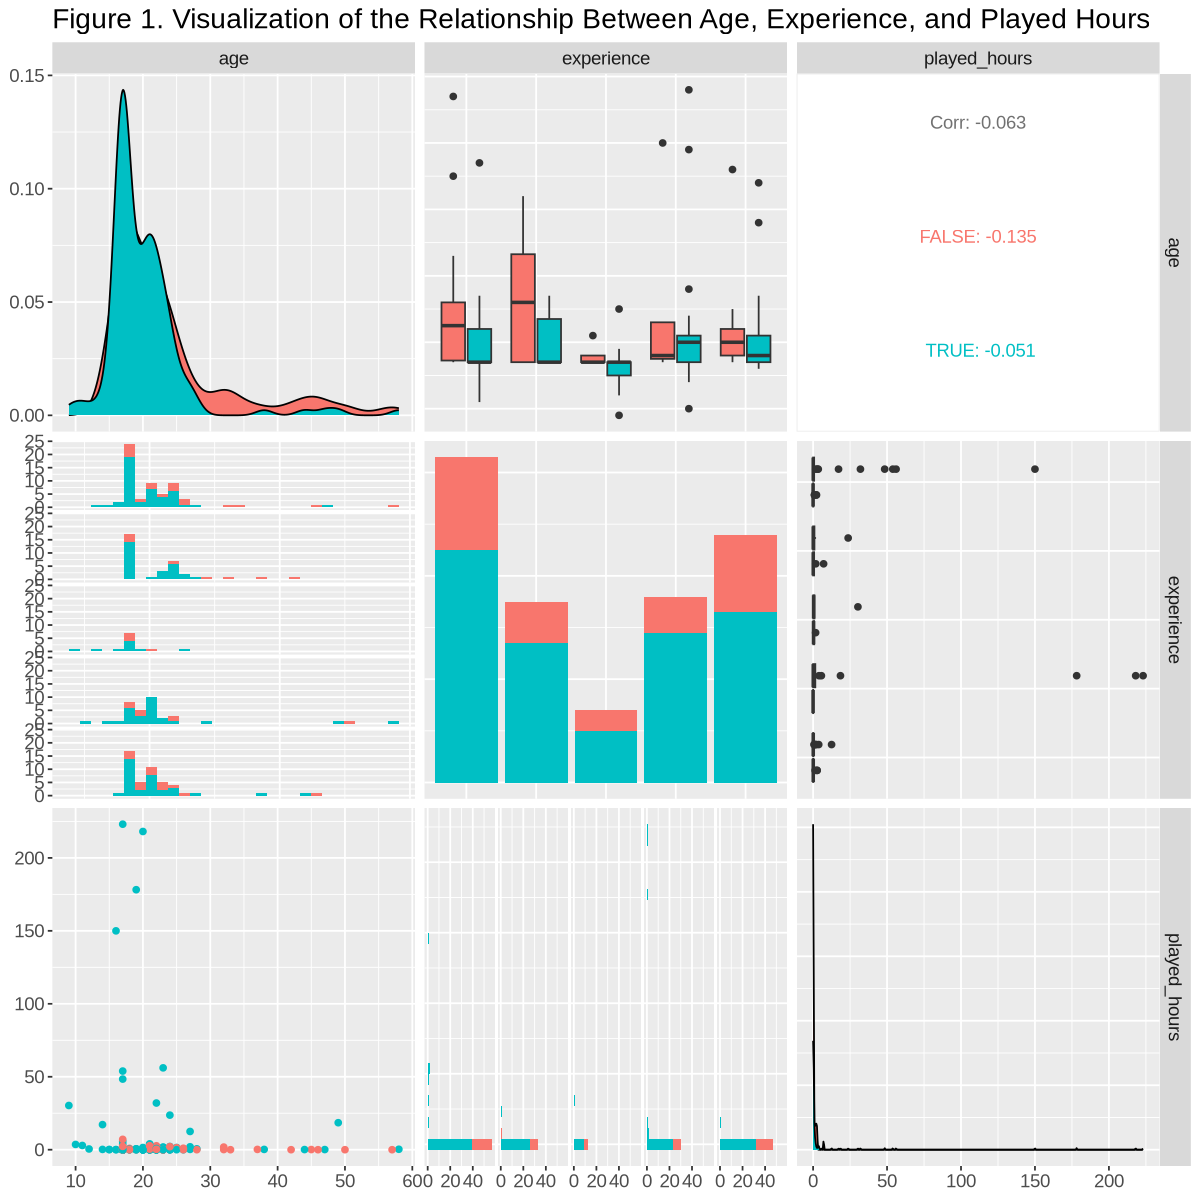

In [5]:
options(repr.plot.width = 10, repr.plot.height = 10)
ggpairs(players, 
        columns = c("age", "experience", "played_hours"), 
        aes(color = subscribe)) +
    ggtitle("Figure 1. Visualization of the Relationship Between Age, Experience, and Played Hours") +
    theme(text = element_text(size = 14))

This pairplot visualizes how each variable relates to every other chosen variable. 

In [22]:
set.seed(2024)

players <- players |>
    select(subscribe, age, experience, played_hours) |>
    mutate(subscribe = as_factor(subscribe)) |>
    drop_na()  # removes rows with missing values
      

#turn experience into numerical values 
#Fixed the problem so don't think we need this part anymore, just didn't want to delete it incase
#someone put it in for a different reason. 
#players <- players |>
   #mutate(experience = recode(experience,
                     #"Beginner" = 1,
                     #"Amateur"  = 2,
                     #"Regular"  = 3,
                     #"Veteran"  = 4,
                     #"Pro"      = 5))

#splitting data
players_split <- initial_split(players, prop = 0.75, strata = subscribe)
players_train <- training(players_split)
players_test <- testing(players_split)

#model k-classification
knn_tune_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

#model recipe
players_recipe <- recipe(subscribe ~ experience + played_hours + age, data = players_train) |>
            step_zv(all_predictors()) |>
            step_scale(all_numeric_predictors()) |>
            step_center(all_numeric_predictors())

#folds
players_vfold <- vfold_cv(players_train, v = 5, strata = subscribe)



#values of k
k_vals <- tibble(neighbors = seq(from = 1, to = 20, by = 1))

#workflow results
knn_results <- workflow() |>
                 add_recipe(players_recipe) |>
                 add_model(knn_tune_spec) |>
                 tune_grid(resamples = players_vfold, grid = k_vals) |>
                 collect_metrics()

#determine the accuracy 
accuracies <- knn_results |>
                  filter(.metric == 'accuracy') |>
                  select(neighbors, mean)


#determines best K value
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 7

In [23]:
set.seed(2024)


#model k-classification
players_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
            set_engine("kknn") |>
            set_mode("classification")

#knn fit
players_fit <- workflow() |>
            add_recipe(players_recipe) |>
            add_model(players_spec) |>
            fit(data = players_train)

                                

In [24]:
set.seed(2024)


#fitting it to testing 
players_test_predictions <- predict(players_fit, players_test) |>
    bind_cols(players_test)


#testing its accuracy 
players_prediction_accuracy <- players_test_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)             

players_prediction_accuracy


#players matrix 
players_mat <-  players_test_predictions |>
    conf_mat(truth = subscribe, estimate = .pred_class)

players_mat



.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.61224490
kap,binary,-0.07381776


          Truth
Prediction FALSE TRUE
     FALSE     2    8
     TRUE     11   28